           ip_src          ip_dst domain                               ja3  \
0  162.223.31.160     10.1.12.101   None                              None   
1  162.223.31.160     10.1.12.101   None  b7ee6f5f9aa5cd17ca1aea43ce848496   
2     10.1.12.101  162.223.31.160   None                              None   
3     10.1.12.101  162.223.31.160   None                              None   
4  162.223.31.160     10.1.12.101   None                              None   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
Model accuracy: 100.00%


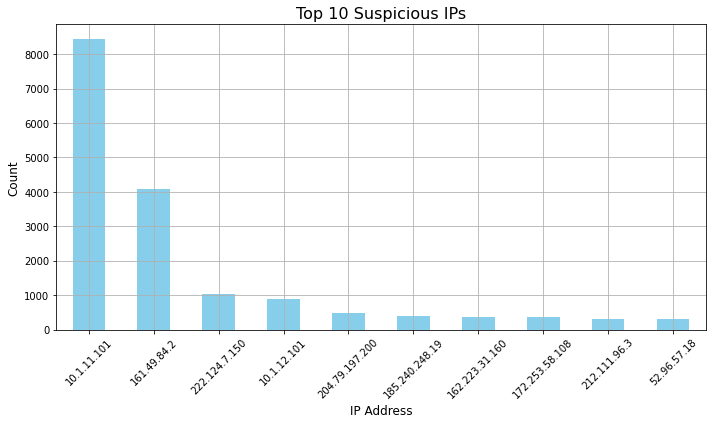

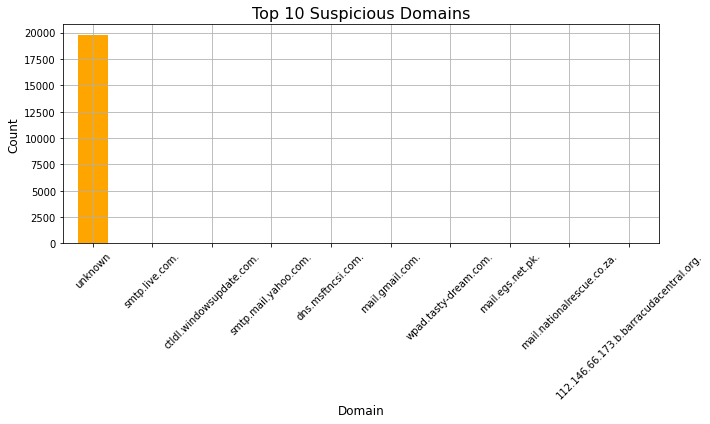

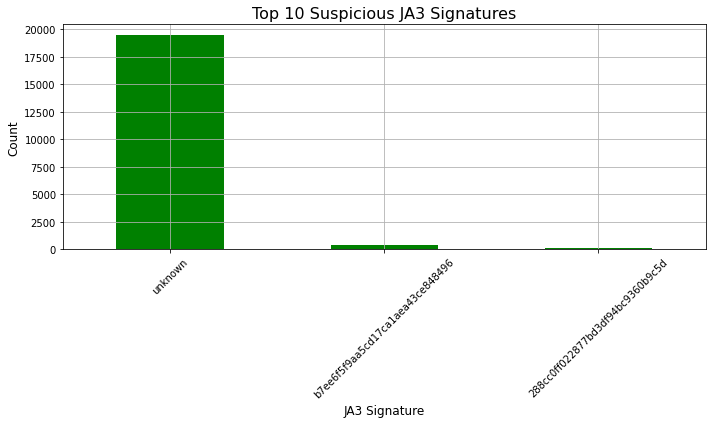

Suspicious IPs Loaded: {'10.0.0.1', '10.1.11.1', '10.1.11.101'}
Matched Locations: {'10.0.0.1': (34.0522, -118.2437)}


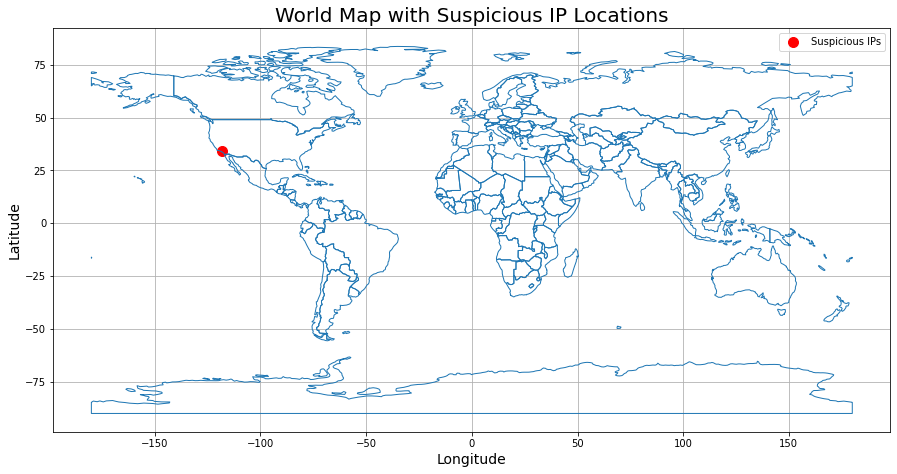

In [10]:
import time
import pandas as pd
import hashlib
from scapy.all import *
from scapy.layers.tls.all import TLSClientHello  # This may fail if TLSClientHello isn't available
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import geopandas as gpd

# Paths to the suspicious files
suspicious_ips_file = 'suspicious_ips.txt'  
suspicious_domains_file = 'suspicious_domains.txt'  
sicious_ja3_file = 'suspicious_ja3.txt'  

# Load suspicious IPs, domains, and JA3 signatures from files
def load_suspicious_data():
    with open(suspicious_ips_file, 'r') as f:
        suspicious_ips = set(line.strip() for line in f)
    
    with open(suspicious_domains_file, 'r') as f:
        suspicious_domains = set(line.strip() for line in f)
    
    with open(sicious_ja3_file, 'r') as f:
        suspicious_ja3 = set(line.strip() for line in f)
    
    return suspicious_ips, suspicious_domains, suspicious_ja3

# Compute JA3 hash from TLS packets
def compute_ja3(packet):
    if packet.haslayer('TLS'):
        tls_layer = packet['TLS']
        version = tls_layer.version if hasattr(tls_layer, 'version') else None
        
        # Extract cipher suites
        cipher_suites = []
        if hasattr(tls_layer, 'ciphers'):
            cipher_suites = [str(cipher) for cipher in tls_layer.ciphers]  # Convert to string list

        # Build the JA3 string
        ja3_string = ",".join(map(str, [version] + cipher_suites))  # Adjusted to concatenate correctly
        ja3_hash = hashlib.md5(ja3_string.encode()).hexdigest()
        return ja3_hash
    return None

# Extract packet features
def extract_packet_features(packet, suspicious_ips, suspicious_domains, suspicious_ja3):
    ip_src, ip_dst, domain, ja3_hash = None, None, None, None

    if packet.haslayer(IP):
        ip_src = packet[IP].src
        ip_dst = packet[IP].dst
    
    if packet.haslayer(DNS):
        dns_layer = packet[DNS]
        if dns_layer.qr == 0:  # Only interested in queries
            domain = dns_layer.qd.qname.decode('utf-8')

    ja3_hash = compute_ja3(packet)
    
    # Label if suspicious
    label = 0
    if ip_src in suspicious_ips or ip_dst in suspicious_ips:
        label = 1
    if domain in suspicious_domains:
        label = 1
    if ja3_hash in suspicious_ja3:
        label = 1

    return [ip_src, ip_dst, domain, ja3_hash, label]

# Read PCAP file and collect features in a DataFrame
def read_pcap_to_dataframe(filename):
    suspicious_ips, suspicious_domains, suspicious_ja3 = load_suspicious_data()
    features = []
    
    with PcapReader(filename) as pcap_reader:
        for packet in pcap_reader:
            try:
                features.append(extract_packet_features(packet, suspicious_ips, suspicious_domains, suspicious_ja3))
            except Exception as e:
                print(f"Error processing packet: {e}")
    
    # Create DataFrame with extracted features
    df = pd.DataFrame(features, columns=["ip_src", "ip_dst", "domain", "ja3", "label"])
    return df

# Train a random forest model
def train_model(df):
    df.fillna("unknown", inplace=True)

    # Use only the IPs, domains, and JA3 as features
    X = df[["ip_src", "ip_dst", "domain", "ja3"]]
    y = df["label"]

    # Convert categorical data to numerical using one-hot encoding
    X = pd.get_dummies(X)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy * 100:.2f}%")

    return model, X_test, y_test, y_pred

# Visualize occurrences of suspicious IPs, domains, and JA3 signatures
def visualize_occurrences(df):
    # Count occurrences
    suspicious_ips_count = df['ip_src'].value_counts()
    suspicious_domains_count = df['domain'].value_counts()
    suspicious_ja3_count = df['ja3'].value_counts()

    # Plot for suspicious IPs
    plt.figure(figsize=(10, 6))
    suspicious_ips_count.head(10).plot(kind='bar', color='skyblue')
    plt.title("Top 10 Suspicious IPs", fontsize=16)
    plt.xlabel("IP Address", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot for suspicious Domains
    plt.figure(figsize=(10, 6))
    suspicious_domains_count.head(10).plot(kind='bar', color='orange')
    plt.title("Top 10 Suspicious Domains", fontsize=16)
    plt.xlabel("Domain", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot for suspicious JA3 signatures
    plt.figure(figsize=(10, 6))
    suspicious_ja3_count.head(10).plot(kind='bar', color='green')
    plt.title("Top 10 Suspicious JA3 Signatures", fontsize=16)
    plt.xlabel("JA3 Signature", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Visualize the world map with suspicious IPs
# Visualize the world map with suspicious IPs
def plot_world_map(suspicious_ips):
    # Load the world map shapefile
    world = gpd.read_file('ne_110m_admin_0_countries.shp')

    # Dummy geolocation for the example (replace this with actual geolocation data)
    ip_locations = {
        '192.0.2.1': (37.7749, -122.4194),  # San Francisco
        '203.0.113.5': (-33.4489, -70.6693),  # Santiago
        '198.51.100.2': (51.5074, -0.1278),  # London
        # Add more dummy IPs with their geolocations here
        '192.168.1.1': (40.7128, -74.0060),  # New York
        '10.0.0.1': (34.0522, -118.2437),     # Los Angeles
        # ... add more as needed
    }

    # Debugging: print suspicious IPs
    print("Suspicious IPs Loaded:", suspicious_ips)

    # Filter to only include suspicious IPs with locations
    locations = {ip: ip_locations[ip] for ip in suspicious_ips if ip in ip_locations}

    # Debugging: print matched locations
    print("Matched Locations:", locations)

    if not locations:  # Check if locations is empty
        print("No matching locations found for suspicious IPs.")
        return  # Exit the function if no locations are found

    latitudes = [loc[0] for loc in locations.values()]
    longitudes = [loc[1] for loc in locations.values()]

    # Create a GeoDataFrame for suspicious IPs
    geometry = gpd.points_from_xy(longitudes, latitudes)
    suspicious_ips_gdf = gpd.GeoDataFrame(geometry=geometry)

    # Plotting the world map
    fig, ax = plt.subplots(figsize=(15, 10))
    world.boundary.plot(ax=ax, linewidth=1)  # Plot the world boundaries
    suspicious_ips_gdf.plot(ax=ax, color='red', markersize=100, label='Suspicious IPs')  # Plot suspicious IPs

    # Customizing the plot
    plt.title('World Map with Suspicious IP Locations', fontsize=20)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    
    if not suspicious_ips_gdf.empty:  # Check if GeoDataFrame is not empty
        plt.legend()
    else:
        print("No suspicious IPs to display on the map.")

    plt.grid(True)

    # Show the plot
    plt.show()

    

# Main function
def main():
    # Path to the PCAP file
    pcap_file = "output_00007_20210112131445.pcap"
    
    # Read the PCAP file and extract features
    df = read_pcap_to_dataframe(pcap_file)
    print(df.head())

    # Train the model
    model, X_test, y_test, y_pred = train_model(df)

    # Visualize occurrences of suspicious elements
    visualize_occurrences(df)

    # Plot the world map with suspicious IPs
    suspicious_ips, suspicious_domains, suspicious_ja3 = load_suspicious_data()
    plot_world_map(suspicious_ips)

if __name__ == "__main__":
    main()

